# CIFAR-10 utils

This notebook contains functions needed to create cifar-10 splits

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# default_exp cifar_utils

In [ ]:
from nbdev.showdoc import *
from nbdev.test import test_eq

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt

from fastai2.basics import L
from fastai2.data.external import untar_data, URLs
from fastai2.data.transforms import *
from fastai2.vision.core import *
from fastai2.vision.learner import *
from fastai2.vision.models.xresnet import xresnet34
from fastai2.data.core import Datasets, DataLoader, TfmdDL
from fastai2.callback.schedule import LRFinder

from collections import Counter

In [ ]:
cifar = untar_data(URLs.CIFAR)
fnames = get_image_files(cifar)

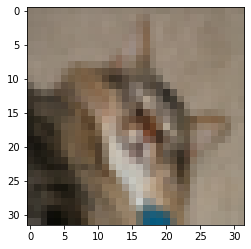

In [ ]:
plt.imshow(PILImage.create(fnames[0]));

In [ ]:
#export
def get_overlap(first, second, n_same):
    "Generate set with `n_same` random items from `first` and other from `second`"

    assert set(first) & set(second) == set(), "Two sets already overlap!"
    assert 0 <= n_same <= len(second), "Too many elements requested"
    
    n_diff = len(second) - n_same
    
    same = list(np.random.choice(first, n_same, replace=False))
    other = list(np.random.choice(second, n_diff, replace=False))
    
    return same + other

In [ ]:
a = ["bird", "cat", "deer", "dog", "frog", "horse"]
b = ["ship", "truck", "airplane", "automobile"]

for i in range(20):
    np.random.seed(i)
    test_eq(len(set(get_overlap(a, b, 4)) & set(a)), 4)
    test_eq(len(set(get_overlap(a, b, 3)) & set(a)), 3)
    test_eq(len(set(get_overlap(a, b, 2)) & set(a)), 2)
    test_eq(len(set(get_overlap(a, b, 1)) & set(a)), 1)
    test_eq(len(set(get_overlap(a, b, 0)) & set(a)), 0)

In [ ]:
#export
class CifarFactory():
    "Create different versions of cifar dataset splits"
    def __init__(self, seed=42, n_labeled=400, n_same_cls=1):
        """
        Initialize cifar split
        Args:
            n_labeled - labeled image per class
            n_same_cls - overlap between labeled and unlabeled classes
        """

        self.seed = seed
        self.n_labeled = n_labeled
        self.n_same_cls = n_same_cls
        
        # Classes split as in paper
        self.animals  = ["bird", "cat", "deer", "dog", "frog", "horse"]
        self.other    = ["ship", "truck", "airplane", "automobile"]

    def splits_from_path(self, path):
        "Create all things needed to setup fastai datasets. returns: fnames, (train, test, unsup)"
        np.random.seed(self.seed)

        # Get all cifar files
        fnames = get_image_files(path)
        labels = L([parent_label(f) for f in fnames])

        # Get only relevant classes
        sup_cls = self.animals
        unsup_cls = get_overlap(self.animals, self.other, self.n_same_cls)
        mask = labels.map(lambda l: l in sup_cls + unsup_cls)
        fnames = fnames[mask]
        labels = labels[mask]
        
        all_train, test = map(L, GrandparentSplitter("train", "test")(fnames))
        test = test.filter(lambda i: labels[i] in sup_cls)
        
        all_train = all_train[np.random.permutation(len(all_train))]
        
        # Split on labeled and unlabeled parts
        class_counts = Counter()
        n_labeled = self.n_labeled
        train, unsup = L(), L()

        for i in all_train:
            l = labels[i]

            if class_counts[labels[i]] < n_labeled:
                class_counts[labels[i]] += 1
                if l in sup_cls: train.append(i)
            elif l in unsup_cls:
                unsup.append(i)
        
        return fnames, (train, test, unsup)
    

In [ ]:
cifar = untar_data(URLs.CIFAR)

len(train), len(test), len(unsup)

(2400, 6000, 18400)

In [ ]:
for i in range(5):
    files, (train, test, unsup) = CifarFactory(n_same_cls=i, n_labeled=400).splits_from_path(cifar)
    cls_train, cnt_train = zip(*Counter([parent_label(o) for o in files[train]]).items())
    cls_unsup, cnt_unsup = zip(*Counter([parent_label(o) for o in files[unsup]]).items())
    cls_test, cnt_test = zip(*Counter([parent_label(o) for o in files[test]]).items())
    
    
    test_eq(len(set(cls_train) & set(cls_test)), 6)
    test_eq(len(set(cls_train) & set(cls_unsup)), i)
    test_eq(list(cnt_train), [400]*6)
    test_eq(list(cnt_unsup), [5000 - 400]*4)
    test_eq(list(cnt_test), [1000]*6)

In [ ]:
Counter([parent_label(o) for o in files[train]])

Counter({'cat': 400,
         'horse': 400,
         'frog': 400,
         'bird': 400,
         'dog': 400,
         'deer': 400})

In [ ]:
Counter([parent_label(o) for o in files[test]])

Counter({'cat': 1000,
         'dog': 1000,
         'bird': 1000,
         'frog': 1000,
         'horse': 1000,
         'deer': 1000})

In [ ]:
Counter([parent_label(o) for o in files[unsup]])

Counter({'bird': 4600, 'horse': 4600, 'cat': 4600, 'deer': 4600})

In [ ]:
test_eq(set(files[unsup]) & set(files[train]), set())
test_eq(set(files[unsup]) & set(files[test]), set())
test_eq(set(files[train]) & set(files[test]), set()) 

Example of using the splitter defined above:

In [ ]:
files, (train, test, unsup) = CifarFactory(n_same_cls=3, n_labeled=400).splits_from_path(cifar)

In [ ]:
sup_ds   = Datasets(files, [[PILImage.create], [parent_label, Categorize]], splits=(train, test))
unsup_ds = Datasets(files, [[PILImage.create]], splits=(unsup,))

In [ ]:
sup_dl = sup_ds.dataloaders(after_item=[ToTensor], after_batch=[IntToFloatTensor, Normalize.from_stats(*cifar_stats)])
unsup_dl = unsup_ds.dataloaders(after_item=[ToTensor], after_batch=[IntToFloatTensor, Normalize.from_stats(*cifar_stats)])

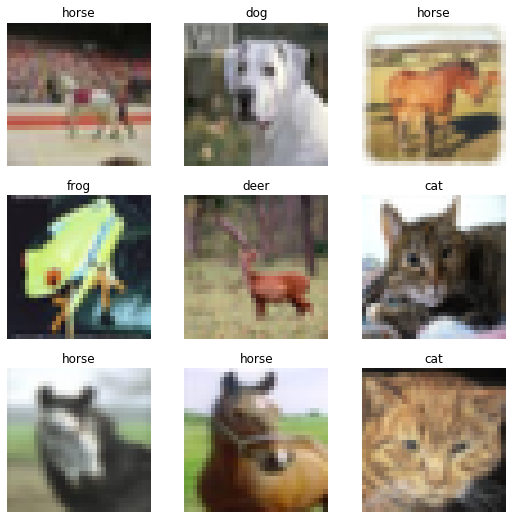

In [ ]:
sup_dl.show_batch(max_n=9)

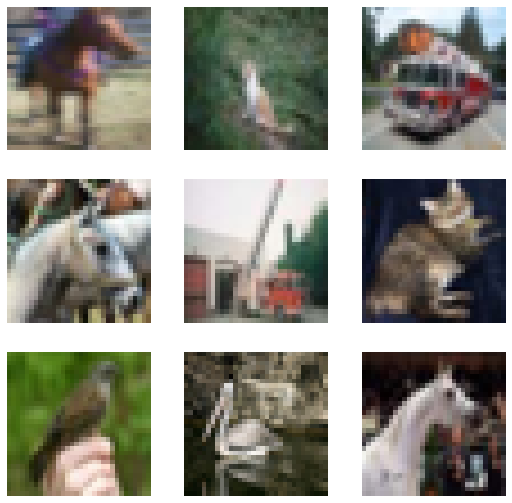

In [ ]:
unsup_dl.show_batch(max_n=9)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_cifar.ipynb.
This cell doesn't have an export destination and was ignored:
e
Converted 01_randaugment.ipynb.
Converted 02_supervised_baselines.ipynb.
Converted index.ipynb.
